Import packages

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

Pick file

In [2]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)
df.head()

,timestamp,message,living_in_city,author,has_emoji
0,2022-09-17 16:05:00,Mensen die vnv nog willen chillen?\n,1,eye-catching-wolf,False
1,2022-09-17 16:06:00,Ik ben nog in Haarlem/Amsterdam\n,0,hypnotic-rabbit,False
2,2022-09-17 16:06:00,Sorry man ik heb feestje van familie\n,1,nutty-chough,False
3,2022-09-17 16:21:00,Ai jammer\n,1,eye-catching-wolf,False
4,2022-09-17 16:22:00,Andere gegadigden?\n,1,eye-catching-wolf,False


Length of message

In [3]:
# Calculate the word count for each message
df['word_count'] = df['message'].str.split().str.len()
df.head() 

,timestamp,message,living_in_city,author,has_emoji,word_count
0,2022-09-17 16:05:00,Mensen die vnv nog willen chillen?\n,1,eye-catching-wolf,False,6
1,2022-09-17 16:06:00,Ik ben nog in Haarlem/Amsterdam\n,0,hypnotic-rabbit,False,5
2,2022-09-17 16:06:00,Sorry man ik heb feestje van familie\n,1,nutty-chough,False,7
3,2022-09-17 16:21:00,Ai jammer\n,1,eye-catching-wolf,False,2
4,2022-09-17 16:22:00,Andere gegadigden?\n,1,eye-catching-wolf,False,2


Time differences between texts

In [6]:
df['time_diff'] = df['timestamp'].diff()
df['react_time_sec'] = df['time_diff'].dt.total_seconds()
df['react_time_min'] = df['react_time_sec'] / 60
df['react_time_hr'] = df['react_time_sec'] / 3600

print(df.head())

            timestamp                                  message  \
0 2022-09-17 16:05:00     Mensen die vnv nog willen chillen?\n   
1 2022-09-17 16:06:00        Ik ben nog in Haarlem/Amsterdam\n   
2 2022-09-17 16:06:00   Sorry man ik heb feestje van familie\n   
3 2022-09-17 16:21:00                              Ai jammer\n   
4 2022-09-17 16:22:00                     Andere gegadigden?\n   

   living_in_city             author  has_emoji  word_count       time_diff  \
0               1  eye-catching-wolf      False           6             NaT   
1               0    hypnotic-rabbit      False           5 0 days 00:01:00   
2               1       nutty-chough      False           7 0 days 00:00:00   
3               1  eye-catching-wolf      False           2 0 days 00:15:00   
4               1  eye-catching-wolf      False           2 0 days 00:01:00   

   react_time_sec  react_time_min  react_time_hr  
0             NaN             NaN            NaN  
1            60.0         

Graph 1

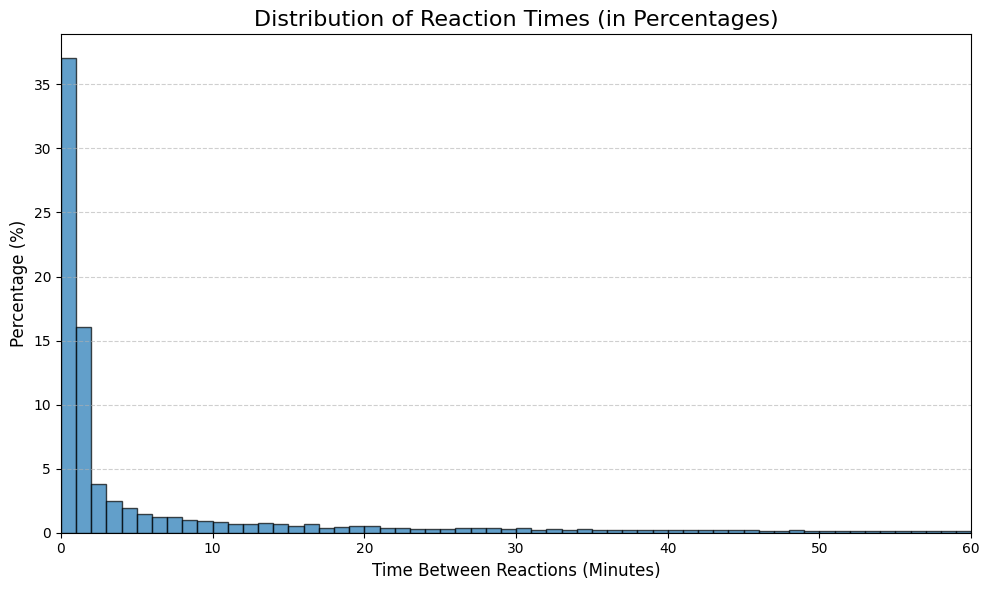

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming df is your DataFrame with 'react_time_min'
# Define the bins
bins = np.arange(0, df['react_time_min'].max() + 1, 1)

# Get the counts for each bin using numpy's histogram function
counts, bin_edges = np.histogram(df['react_time_min'].dropna(), bins=bins)

# Calculate the percentages
total_entries = len(df['react_time_min'].dropna())
percentages = (counts / total_entries) * 100

plt.figure(figsize=(10, 6))

# Plot the percentages using plt.bar()
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.bar(bin_centers, percentages, width=1, edgecolor='black', alpha=0.7)

plt.title('Distribution of Reaction Times (in Percentages)', fontsize=16)
plt.xlabel('Time Between Reactions (Minutes)', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xlim(0, 60) # Keep the x-axis limit as requested

plt.tight_layout()
plt.savefig('reaction_time_percentage_hist.png')

Graph 2

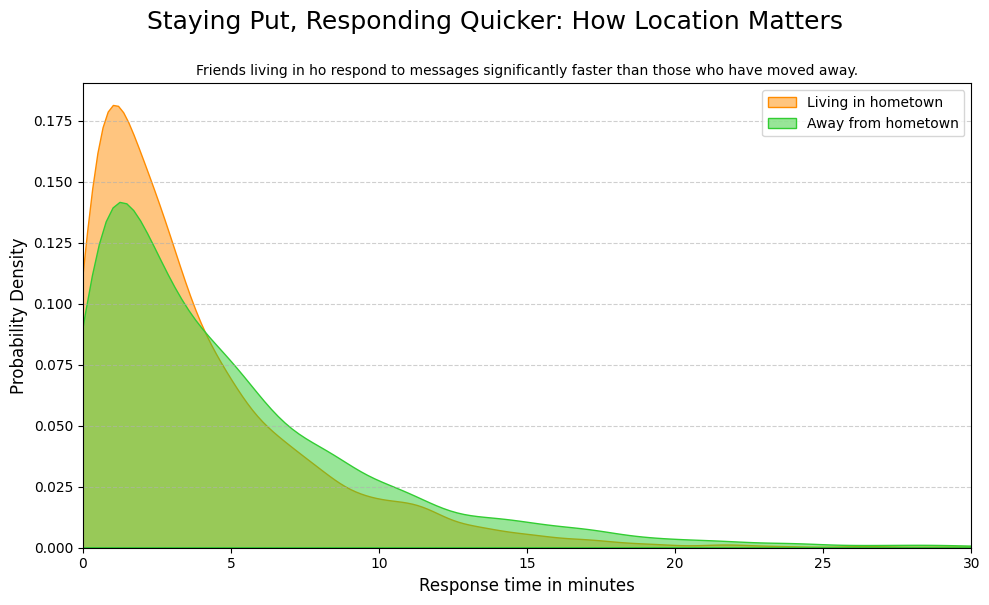

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assuming df is loaded and has the 'living_in_city' and 'react_time_min' columns
# Let's create some dummy data to make the code runnable
np.random.seed(42)
data1 = np.random.exponential(scale=5, size=5000)
data2 = np.random.exponential(scale=5, size=5000) * 0.8
df = pd.DataFrame({
    'react_time_min': np.concatenate([data1, data2]),
    'living_in_city': np.concatenate([np.ones(5000), np.zeros(5000)])
})

city_dwellers = df[df['living_in_city'] == 1]['react_time_min']
non_city_dwellers = df[df['living_in_city'] == 0]['react_time_min']

plt.figure(figsize=(10, 6))

# Use seaborn for KDE to get the smooth distribution curves
sns.kdeplot(non_city_dwellers, color='darkorange', fill=True, alpha=0.5, label='Living in hometown')
sns.kdeplot(city_dwellers, color='limegreen', fill=True, alpha=0.5, label='Away from hometown')

# Subtitle
plt.suptitle('Staying Put, Responding Quicker: How Location Matters', fontsize=18, y=1.0)

# title
plt.title('Friends living in ho respond to messages significantly faster than those who have moved away.', fontsize=10, loc='center', y = 1.0)

plt.xlabel('Response time in minutes', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.xlim(0, 30)
plt.legend(loc='upper right')
plt.tight_layout()

# Save the figure to a file
plt.savefig('reaction_times_plot.png', dpi=300)

plt.show()